In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import pickle
import numpy as np
from PIL import Image
from typing import List
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
# from insightface.app import FaceAnalysis
from sklearn.neighbors import NearestNeighbors

### Build Dataset

In [2]:
labels = [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
                  0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]

repetition_count = 15

new_labels = [num for num in labels for _ in range(repetition_count)]

print(len(new_labels))
labels = np.array(labels)

750


In [ ]:
labels = []

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def cut_face(image, file_name, number):

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faces1 = face_cascade.detectMultiScale(image, scaleFactor=1.3, minNeighbors=3, minSize=(40, 40))
    print(number)
    for (x, y, w, h) in faces1:
        face_image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 4)

    # image = Image.fromarray(face_image)
    # plt.imshow(face_image, cmap='viridis')
    try:
        bgr_face_image = cv2.cvtColor(face_image, cv2.COLOR_RGB2BGR)
        file_name = "new/" + str(number) + file_name

        cv2.imwrite(file_name, bgr_face_image)
    except:
        print(file_name)

In [ ]:
directory1 = 'drive/MyDrive/gt_db_edit'
file_names1 = sorted(os.listdir(directory1))
number = 1
for file_name1 in file_names1:
    directory2 = "drive/MyDrive/gt_db_edit/" + file_name1
    file_names2 = sorted(os.listdir(directory2))
    for file_name2 in file_names2:

        image_name = directory2 + "/" + file_name2
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cut_face(image, file_name2, number)
        number = number + 1

### Dimention Reduction

In [3]:
directory = 'drive/MyDrive/final-faces (copy)'
images = []

for image in sorted(os.listdir(directory)):
    # img = Image.open("drive/MyDrive/final-faces (copy)/" + image)
    face_img = cv2.imread(directory + "/" + image, cv2.IMREAD_GRAYSCALE)

    resized_img = cv2.resize(face_img, (132,132), interpolation = cv2.INTER_AREA)

    images.append(resized_img)

print(len(images))

750


In [8]:
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
import numpy as np



def extract_hog_features(image):
    hog_features, _ = hog(image, orientations=8, pixels_per_cell=(16, 16),
                         cells_per_block=(1, 1), visualize=True, block_norm='L2-Hys')
    return hog_features

def extract_lbp_features(image):
    lbp_radius = 3
    lbp_points = 24
    lbp_features = local_binary_pattern(image, lbp_points, lbp_radius, method='uniform')
    flattened_lbp = lbp_features.ravel()
    return flattened_lbp



hog_features_list = []
lbp_features_list = []

for image in images:
    hog_features = extract_hog_features(image)
    lbp_features = extract_lbp_features(image)
    hog_features_list.append(hog_features)
    lbp_features_list.append(lbp_features)

X_hog = np.array(hog_features_list)

X_lbp = np.array(lbp_features_list)

(750, 512)
(750, 17424)


In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

X_hog_standardized_features = scaler.fit_transform(X_hog)
X_lbp_standardized_features = scaler.fit_transform(X_lbp)

n_components = 256
pca = PCA(n_components=n_components)

X_hog_pca = pca.fit_transform(X_hog_standardized_features)
X_lbp_pca = pca.fit_transform(X_lbp_standardized_features)

In [10]:
print(X_hog.shape)
print(X_lbp.shape)
print(X_hog_pca.shape)
print(X_lbp_pca.shape)

(750, 512)
(750, 17424)
(750, 256)
(750, 256)


In [18]:
y = np.array(new_labels)

X_hog_train, X_hog_test, y_hog_train, y_hog_test = train_test_split(
    X_hog, y, test_size=0.25, random_state=42
)

X_lbp_train, X_lbp_test, y_lbp_train, y_lbp_test = train_test_split(
    X_lbp, y, test_size=0.25, random_state=42
)

X_hog_pca_train, X_hog_pca_test, y_hog_pca_train, y_hog_pca_test = train_test_split(
    X_hog_pca, y, test_size=0.25, random_state=42
)

X_lbp_pca_train, X_lbp_pca_test, y_lbp_pca_train, y_lbp_pca_test = train_test_split(
    X_lbp_pca, y, test_size=0.25, random_state=42
)

### Training

(HOG) Accuracy: 0.8563829787234043
(HOG + PCA) Accuracy: 0.8617021276595744
(LBP) Accuracy: 0.851063829787234
(LBP + PCA) Accuracy: 0.8297872340425532


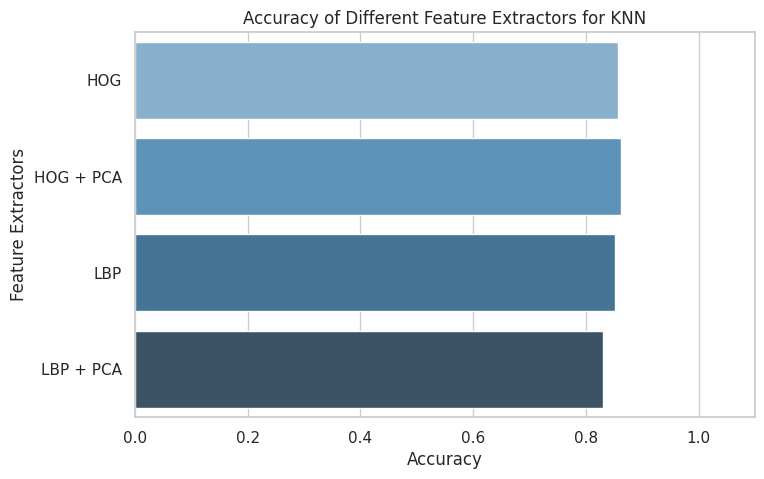

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def KNN(X_train,X_test, y_train, y_test):
  knn = KNeighborsClassifier(n_neighbors=5)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  return accuracy

KNN_HOG = KNN(X_hog_train, X_hog_test, y_hog_train, y_hog_test)
KNN_PCA_HOG = KNN(X_hog_pca_train, X_hog_pca_test, y_hog_pca_train, y_hog_pca_test)
KNN_LBP = KNN(X_lbp_train, X_lbp_test, y_lbp_train, y_lbp_test)
KNN_PCA_LBP = KNN(X_lbp_pca_train, X_lbp_pca_test, y_lbp_pca_train, y_lbp_pca_test)


print("(HOG) Accuracy:", KNN_HOG)
print("(HOG + PCA) Accuracy:", KNN_PCA_HOG)
print("(LBP) Accuracy:", KNN_LBP)
print("(LBP + PCA) Accuracy:", KNN_PCA_LBP)

accuracy_values = [KNN_HOG, KNN_PCA_HOG, KNN_LBP, KNN_PCA_LBP]
labels = ['HOG', 'HOG + PCA', 'LBP', 'LBP + PCA']

# Create a horizontal bar plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(x=accuracy_values, y=labels, palette="Blues_d")

plt.xlim(0, 1.1)  # Set x-axis limit
plt.xlabel('Accuracy')
plt.ylabel('Feature Extractors')
plt.title('Accuracy of Different Feature Extractors for KNN')
plt.show()

(HOG) Accuracy: 0.8723404255319149
(HOG + PCA) Accuracy: 0.8297872340425532
(LBP) Accuracy: 0.8617021276595744
(LBP + PCA) Accuracy: 0.8191489361702128


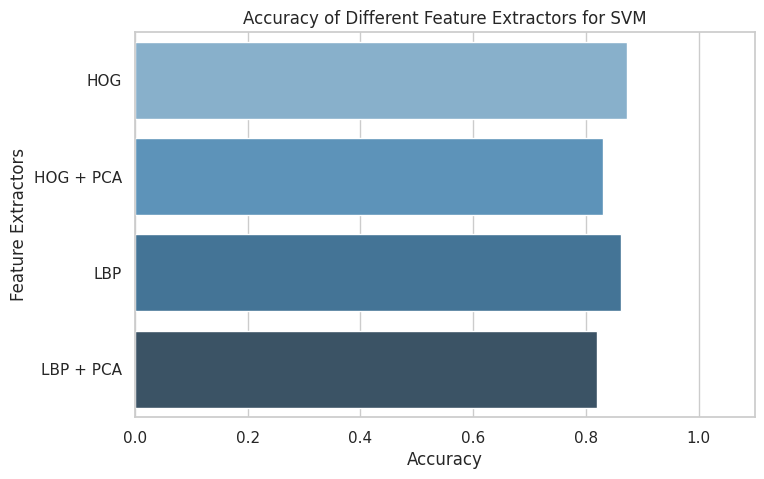

In [42]:
from sklearn.svm import SVC

def SVM(X_train,X_test, y_train, y_test):
  svm_classifier = SVC(kernel='linear')
  svm_classifier.fit(X_train, y_train)
  y_pred = svm_classifier.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  return accuracy


SVM_HOG = SVM(X_hog_train, X_hog_test, y_hog_train, y_hog_test)
SVM_PCA_HOG = SVM(X_hog_pca_train, X_hog_pca_test, y_hog_pca_train, y_hog_pca_test)
SVM_LBP = SVM(X_lbp_train, X_lbp_test, y_lbp_train, y_lbp_test)
SVM_PCA_LBP = SVM(X_lbp_pca_train, X_lbp_pca_test, y_lbp_pca_train, y_lbp_pca_test)


print("(HOG) Accuracy:", SVM_HOG)
print("(HOG + PCA) Accuracy:", SVM_PCA_HOG)
print("(LBP) Accuracy:", SVM_LBP)
print("(LBP + PCA) Accuracy:", SVM_PCA_LBP)

accuracy_values = [SVM_HOG, SVM_PCA_HOG, SVM_LBP, SVM_PCA_LBP]
labels = ['HOG', 'HOG + PCA', 'LBP', 'LBP + PCA']

# Create a horizontal bar plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(x=accuracy_values, y=labels, palette="Blues_d")

plt.xlim(0, 1.1)  # Set x-axis limit
plt.xlabel('Accuracy')
plt.ylabel('Feature Extractors')
plt.title('Accuracy of Different Feature Extractors for SVM')
plt.show()

(HOG) Accuracy: 0.8670212765957447
(HOG + PCA) Accuracy: 0.8617021276595744
(LBP) Accuracy: 0.8617021276595744
(LBP + PCA) Accuracy: 0.8617021276595744


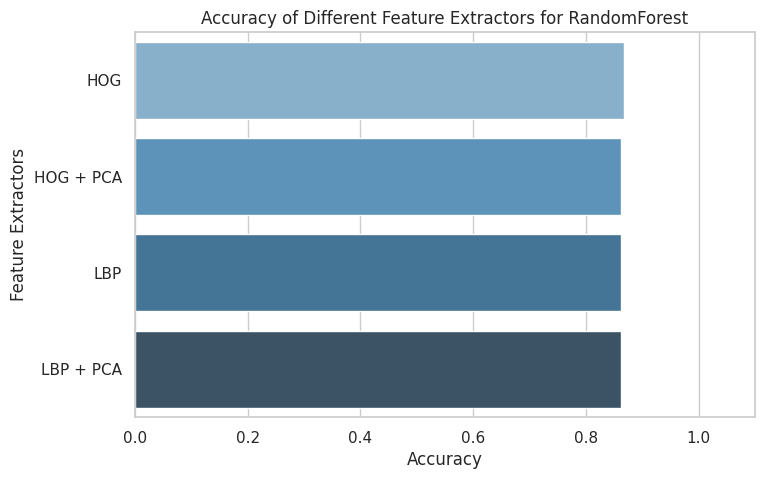

In [53]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

def XGBoost(X_train, X_test, y_train, y_test):
    xgboost_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)
    xgboost_classifier.fit(X_train, y_train)
    y_pred = xgboost_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

XGBoost_HOG = XGBoost(X_hog_train, X_hog_test, y_hog_train, y_hog_test)
XGBoost_PCA_HOG = XGBoost(X_hog_pca_train, X_hog_pca_test, y_hog_pca_train, y_hog_pca_test)
XGBoost_LBP = XGBoost(X_lbp_train, X_lbp_test, y_lbp_train, y_lbp_test)
XGBoost_PCA_LBP = XGBoost(X_lbp_pca_train, X_lbp_pca_test, y_lbp_pca_train, y_lbp_pca_test)

print("(HOG) Accuracy:", XGBoost_HOG)
print("(HOG + PCA) Accuracy:", XGBoost_PCA_HOG)
print("(LBP) Accuracy:", XGBoost_LBP)
print("(LBP + PCA) Accuracy:", XGBoost_PCA_LBP)

accuracy_values = [XGBoost_HOG, XGBoost_PCA_HOG, XGBoost_LBP, XGBoost_PCA_LBP]
labels = ['HOG', 'HOG + PCA', 'LBP', 'LBP + PCA']

# Create a horizontal bar plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(x=accuracy_values, y=labels, palette="Blues_d")

plt.xlim(0, 1.1)  # Set x-axis limit
plt.xlabel('Accuracy')
plt.ylabel('Feature Extractors')
plt.title('Accuracy of Different Feature Extractors for RandomForest')
plt.show()

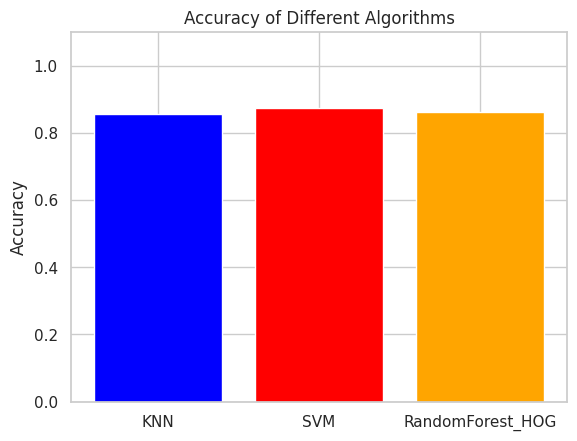

In [47]:
algorithms = ['KNN', 'SVM', 'RandomForest_HOG']
accuracies = [KNN_HOG, SVM_HOG, RandomForest_HOG]

plt.bar(algorithms, accuracies, color=['blue', 'red', 'orange'])
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Algorithms')
plt.show()